In [2]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

# Решающие деревья

На данный момент мы уже познакомились с основными задачами, которые решаются в обучении с учителем:
* определение регрессии
* классификация.

Более того, мы не только узнали, но и реализовали две модели: линейной и логистической регрессии. Обе модели по своей природе являются линейными, но тем не менее позволяют решать уже очень много различных задач, которые по природе своей сводятся либо к задаче определения регрессии, либо к классификации - мы в этом убедились в лабораторных работах!

Но что если в задаче регрессии зависимости перестают быть линейными и становятся сильно нелинейными? Или в классификации уже не получается разделить данные на классы прямыми линиями? Нужен инструмент посерьезнее!

В этой практике мы дойдем до рассмотрения модели под названием **Случайный лес (Random Forest)**. Он основывается на более простых моделях под названием **Решающие деревья (Decision Trees)**, их мы тоже рассмотрим!

Зачем нам другие модели, если мы уже знаем как минимум две (а может и больше)? Ранее использованные модели достаточно простые и описывают данные таким образом, как и задумывается. То есть линейная регрессия (если не генерировать полиномиальные признаки) описывает данные линейной зависимостью. Аналогично, логистическая регрессия, мы точно знаем, что разделение будет прямой линией. Это дает нам уверенность, что модель точно не переобучится (overfit), возможно, недообучится (underfit), но это проще заметить, так как сразу видно, что у модели низкая точность по показателям. Для определения переобучения надо приложить больше внимательности.

> Еще раз уточним, что переобучение плохо тем, что модель перестает видеть зависимость в данных, а начинает ориентироваться на шум и запоминать данные. На новых данных будет мнооого ошибок.

Тем не менее, часто зависимости бывают сложные и нелинейные, поэтому дальнейшие новые модели - это уже серьезные инструменты. Их тоже можно настраивать и мы научимся этим пользоваться, а пока помните принцип "бритвы Оккама" - не усложняй. Если зависимости в данных простые - сложные модели не нужны. Если всё-таки данные сложные - давайте научимся, как пользоваться уже недетскими штучками!

Решающее дерево - это модель, которая все время что-то выбирает. Для примера взглянем на решающее дерево, которое классифицирует, будем играть в футбол или нет:

![Решающее дерево](https://docs.google.com/uc?export=download&id=1jT-uZf7Og09ZpOMKwj4HqSdcraHgNL0e)

> Напоминает игру "20 вопросов", не так ли? Когда тебе загадали знаменитось и ты пытаешься отгадать за счет вопросов с ответами Да/Нет.

Само решающее дерево состоит из узлов (синие ячейки, фиолетовая - корневой узел) и листьев (зеленые ячейки). В машинном обучении применяются бинарные деревья (только Да/Нет).

Узлы проверяют значения признаков, листья - это конкретные классы.

Как происходит предсказание с использованием рещающего дерева? Построенное дерево представляет собой структуру, в которой в каждом узле принимается решение о том, больше или меньше значение определенного признака $m$ чем какой-то порог. Попадая на листья, мы получаем класс предсказания.

Например, пускай в наших данных одним из признаков является стоимость, тогда узлом дерева может быть принятие решения "является ли стоимость больше 10 у.е.". Таким образом, имея новую запись данных, мы спускаемся по дереву, проверяя признаки на превышение порога, заданного в узле - так выбирается куда идти, в левую или правую ветку.

Таким образом, функция предсказания дерева - набор условных проверок, каждая из которых имеет определенное число (порог) для признака, зафиксированного в узле.

Для того, чтобы реализовать функцию предсказания, требуется в первую очередь разобраться, как дерево строится и как представляется.

# Решающее дерево для классификации

Для того, чтобы разобраться, как деревья строятся, посмотрим на набор данных из двух признаков (чтобы была возможность визуализации):

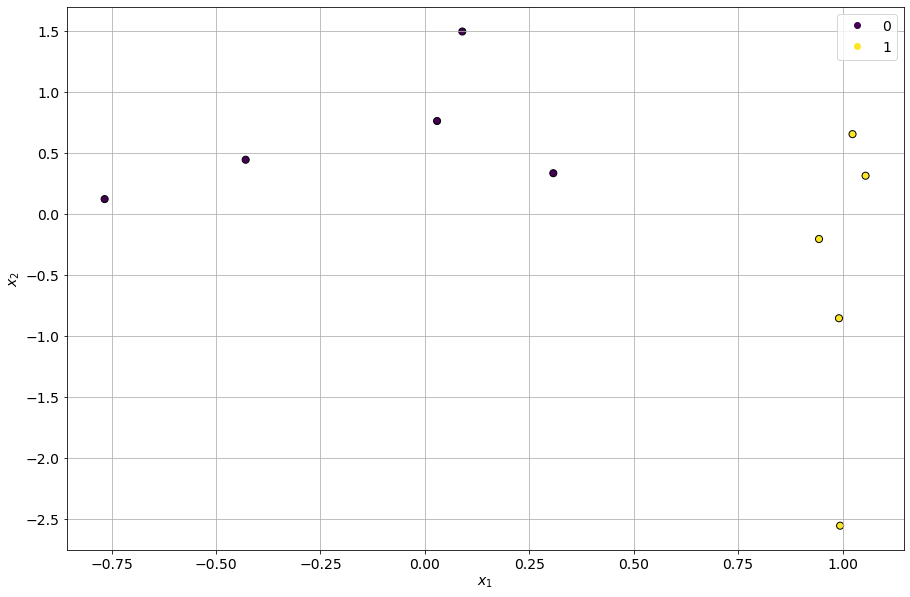

In [3]:
from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=10,
    n_features=2, 
    n_redundant=0,
    n_informative=1, 
    n_clusters_per_class=1,
    random_state=RANDOM_STATE
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

Обратите внимание на данные, классы очень хорошо разделены и человек сразу понимает, проведите линию на уровне $x_1=0.5$ и мы получим идеальную классификацию по единственному признаку $x_1$: класс 1, если $x_1 > 0.5$ и класс 1 в ином случае. 

Попробуйте сформулировать условия как дерево решений:

<details>
    <summary>Решение</summary>

![Картинка](https://docs.google.com/uc?export=download&id=1FdEVwJlMRo4YTdlZzZT9_X03jq2bpQJs)
</details>





Как видно из представления решающего дерева, для корректной классификации достаточно дерева с единственным корневым узлом и глубиной равной единице.

> Глубина дерева - это количество узлов, уходящих "вниз". В примере с игрой в футбол глубина дерева равна трем.

Но не забывайте, что это дерево построено нами, а как сделать это алгоритмически на основе данных?

# Примеси Джини (Gini impurity)

Примеси Джини - это коэффициент, который показывает, сколько в наборе данных примесей. Под "примесями" понимается неоднородность классов в данных. То есть, в нашем наборе пять записей с классом 0 и пять - с классом 1. Для понимания, данные без примесей - данные *только* с классом 0 или 1.

Формула коэффициента следующая:
$$
G = \sum_{k=1}^{K} p(k)*(1-p(k))
$$
где $K$ - количество классов в данных, $p(k)$ - вероятность выбора класса $k$ из данных.

Что такое "вероятность выбора класса"? Просто, каков шанс, что выбрав из данных запись, он окажется с этим классом. А как посчитать вероятность выскивания зеленого шарика из корзинки с зелеными и синими шариками, если мы знаем, что в корзине 5 синих и 5 зеленых? Правильно, просто поделить количество зеленых на общее количество!

Так и мы тут делаем, посчитаем ручками:
$$
G = \frac{5}{10}*(1-\frac{5}{10}) + 
\frac{5}{10}*(1-\frac{5}{10}) 
= 0.5*0.5 + 0.5*0.5 = 0.5
$$

Сколько половинок в этой формуле, ничего не понятно, давайте попробуем более неравномерное разделение? Допустим имеем корзинку из 10 шариков, 2 из них синие, 8 - зеленые. Посчитаем примеси Джини:
$$
G = \frac{2}{10}*(1-\frac{2}{10}) + 
\frac{8}{10}*(1-\frac{8}{10}) 
= 0.2*0.8 + 0.8*0.2 = 0.32
$$

И для контраста посчитаем, что если в корзине 10 шариков и все зеленые (хотя мы еще знаем про синие):
$$
G = \frac{10}{10}*(1-\frac{10}{10}) +
\frac{0}{10}*(1-\frac{0}{10}) = 0
$$

Вот мы провели расчеты, но что это дало? Первое и самое важное - в первых двух случая есть примеси и, судя по показателю, в первом случае их больше, чем во втором. В третьем случае примесей нет совсем.


Давайте напишем реализацию этой функции:

In [4]:
# TODO - напишите реализацию функции вычисления Джини
def gini_impurity(y):
    if (y.shape[0] == 0):
      return 0
    # на самом деле для этого случая (класса всего 2) можно вычислять только одно
    # слагаемое и умножать на два
    gini0 = (np.sum(y==0)/y.shape[0])*(1-np.sum(y==0)/y.shape[0])
    gini1 = (np.sum(y==1)/y.shape[0])*(1-np.sum(y==1)/y.shape[0])
    gini = gini0 + gini1
    return gini

In [5]:
# TEST
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
y2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y3 = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
y4 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

assert gini_impurity(y1) == 0.5
assert gini_impurity(y2) == 0
assert gini_impurity(y3) == 0.32
assert gini_impurity(y4) == 0
assert gini_impurity(np.array([])) == 0

Для чего нам нужен этот показатель? Суть решающего дерева заключается в том, что каждым узлом производится раздел пространства на части. То есть, если мы говорим, что узел разделяет по признаку $x_1$ с порогом 0.5, то все пространство правее линии $x_1 = 0.5$ становится классом 1, а все левее этой линии - классом 0. Для проверки напишем первый вариант функции предсказания и построим визуализацию решений модели.

In [6]:
# TODO
def predict_v1(X):
    # Напишите реализацию функции предсказания
    #   решающего дерева с одним узлом
    #   разделение по признаку (x1) с порогом 0.5
    # *Не забывайте о размерности данных X
    y_pred = (X[:,0]>0.5)
    return y_pred

In [7]:
# TEST
X = np.array([
    [1, 1],
    [2, 1],
    [0, 1],
])

assert np.all(predict_v1(X) == np.array([1, 1, 0]))

Теперь вернемся к нашим данным и посмотрим, как работает предсказание разделением по единственному признаку:

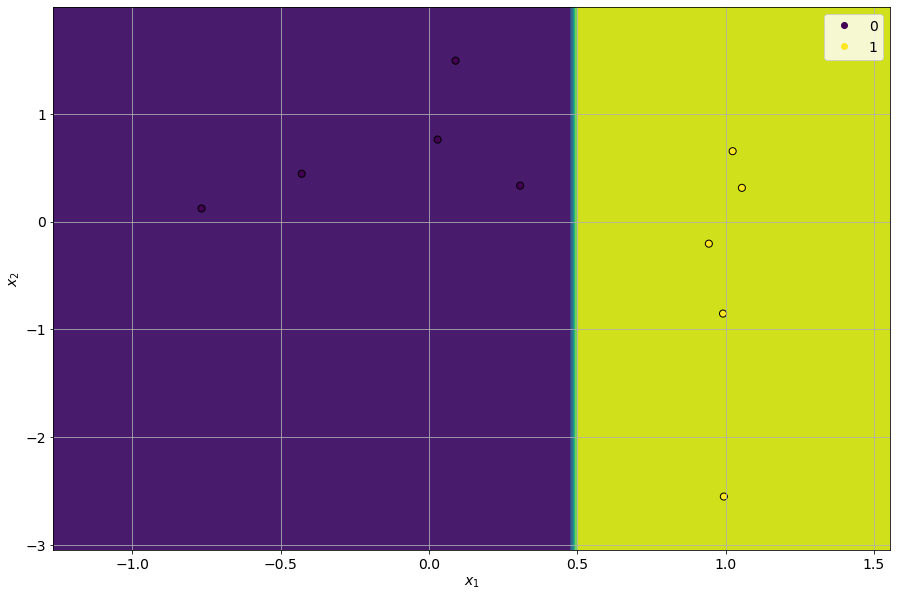

In [8]:
X = X_data
y_true = y_data

x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
xx, yy = np.meshgrid(x1_vals, x2_vals)
space_X = np.c_[xx.ravel(), yy.ravel()]

y_pred = predict_v1(space_X)
y_pred = y_pred.reshape(xx.shape)

plt.contourf(xx, yy, y_pred)
pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.show()

Как видно, реализация дерева с одним узлом разделяет пространство решений на две части. Если добавить еще узлов в дерево, то разделение будет продолжаться прямыми линиями дальше (это мы увидим в дальнейших шагах).

Сейчас важно понять, как нам создать такое разделение автоматически?

Для начала, мы же не знаем лучшее разделение из данных - нам надо получить его автоматически. Попробуем три разных порога для разделения данных по признаку $x_1$ (который стоит в колонке 0) и посчитаем примеси Джини каждой части после разделения:

In [9]:
thresholds = [-0.5, 0.5, 1]
feature_index = 0

X = X_data
y_true = y_data

gini_full = gini_impurity(y_true)
print(f'Gini full: {gini_full} | count: {len(y_true)}')

for threshold in thresholds:
    print(f'\tSplit by {threshold}')
    split_mask = X[:, feature_index] > threshold
    y_true_left = y_true[split_mask]
    y_true_right = y_true[~split_mask]
    
    gini_left = gini_impurity(y_true_left)
    gini_right = gini_impurity(y_true_right)

    print(f'\t\tGini left: {gini_left} | element count: {len(y_true_left)}')
    print(f'\t\tGini right: {gini_right} | element count: {len(y_true_right)}')

Gini full: 0.5 | count: 10
	Split by -0.5
		Gini left: 0.49382716049382713 | element count: 9
		Gini right: 0.0 | element count: 1
	Split by 0.5
		Gini left: 0.0 | element count: 5
		Gini right: 0.0 | element count: 5
	Split by 1
		Gini left: 0.0 | element count: 2
		Gini right: 0.46875 | element count: 8


По выводу видно, что после того или иного разделения показатели меняются, но как нам понять, стало лучше или хуже? 

Давайте возьмем сумму левого и правого показателей! По идее, чем меньше сумма - тем лучше разделение, так как примесей становится меньше (неопределенности класса). Только учтем маленькую особенность, мы каждому значению примеси добавили вес. Так мы получим взвешенную сумму!

Вес мы будем вычислять следующим образом, вот у нас есть 10 элементов до разделения, при делении по -0.5 мы получаем ветки с девятью и одним элементом. Значит для левой ветки вес будет $9/10$, а для правой $1/10$. То есть, новый показатель будет равен: $0.9*0.49+0.1*0 = 0.44$.

Зачем взвешивать сумму? Маленький показатель примесей - это круто, например 0.1, но вот только если его получили сотней элементов это намного лучше, чем, если он получен десятью элементами. То есть, если много элементов дают маленький показатель примесей, то это более желаемый кейс, чем тот же показатель, но меньшее число элементов.

Давайте сделаем расчет в нашем случае:

In [10]:
thresholds = [-0.5, 0.5, 1]
feature_index = 0

X = X_data
y_true = y_data


gini_full = gini_impurity(y_true)
print(f'Gini full: {gini_full}')

for threshold in thresholds:
    print(f'\tSplit by {threshold}')
    split_mask = X[:, feature_index] > threshold
    y_true_left = y_true[split_mask]
    y_true_right = y_true[~split_mask]
    
    gini_left = gini_impurity(y_true_left)
    gini_right = gini_impurity(y_true_right)

    print(f'\t\tGini left: {gini_left}')
    print(f'\t\tGini right: {gini_right}')
    
    weight_left = len(y_true_left)/len(y_true)
    weight_right = len(y_true_right)/len(y_true)
    weighted_gini = weight_left * gini_left + weight_right * gini_right
    print(f'\t\tGini after split: {weighted_gini}')
    print(f'\t\tGini gain: {gini_full-weighted_gini}')

Gini full: 0.5
	Split by -0.5
		Gini left: 0.49382716049382713
		Gini right: 0.0
		Gini after split: 0.4444444444444444
		Gini gain: 0.05555555555555558
	Split by 0.5
		Gini left: 0.0
		Gini right: 0.0
		Gini after split: 0.0
		Gini gain: 0.5
	Split by 1
		Gini left: 0.0
		Gini right: 0.46875
		Gini after split: 0.375
		Gini gain: 0.125


Вывод разницы между исходным показателем и после разделения называется "прирост Джини" (Gini Gain). Таким образом, если показатель стал меньше, значит в разделении стало меньше примесей. То есть, чем больше прирост Джини, тем лучше разделение. Крайний случай - ноль. При нуле происходит идеальное разделение между классами.

> Не совсем очевидно, но "прирост Джини" - это величина уменьшения этого показателя в результате разделения.

Таким образом, мы вывели правило, по которому производится оценка того, как выбрано разделение (параметры узла). Что же нам остается? Понять, а как же всё-таки выбирать, по каким признакам и какие пороги ставить?

> Не забывайте, что сейчас мы пороги задавали сами.

# Выбор лучшего разделения (сплита)

Ответ: ничего особенного, мы будем делать жадный перебор =)

Почему? Да потому что это просто! То есть, суть алгоритма выбора признака для разделения и порога по этому признаку будет заключаться в том, что мы будем перебирать каждый индекс признака и в рамках этого признака - каждую запись в качестве порога.

То есть, в качестве псевдокода можно записать так:
```
Цикл по всем признакам
    Цикл по всем записям
        Берем значение признака в этой записи в качестве порога
        Делаем разделение
        Вычисляем примеси Джини
        Если прирост Джини больше, чем сохраненный,
            то сохранить индекс признака и значение порога,
            а также обновить лучшую примесь 
            и взвешенную сумму примесей
```

А теперь, реализуйте его в качестве функции:

In [11]:
def get_best_split(X, y_true):
    best_gini_gain = 0
    best_gini_impurity = 0
    best_feature_idx = 0
    best_threshold = 0
    
    gini_full = gini_impurity(y_true)

    # TODO - дополните реализацию функции получения наилучшего разделения

    for i in range(X.shape[1]):# признаки
      for j in range(X.shape[0]): # записи
        threshold = X[j,i] # бежим по столбцу - признкам
        split_mask = (X[:, i] >  threshold) # сранививаем все записи с 
        # признаком - порогом
        y_true_left = y_true[split_mask]
        y_true_right = y_true[~split_mask]  

         # вычисляем примеси джини
        gini_left = gini_impurity(y_true_left)
        gini_right = gini_impurity(y_true_right)

        # взвешиваем
        weight_left = len(y_true_left)/len(y_true)
        weight_right = len(y_true_right)/len(y_true)
        
        # взвешенная джини
        weighted_gini = weight_left * gini_left + weight_right * gini_right
        
        # проверяем разницу в приросте Джини
        prirost = gini_full-weighted_gini

        if (prirost > best_gini_gain):
          best_feature_idx = i
          best_threshold =  threshold
          best_gini_impurity = weighted_gini
          best_gini_gain = prirost

    return best_gini_impurity, best_feature_idx, best_threshold

In [12]:
# TEST
X = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(-1, 1)
y = np.array([1, 1, 1, 1, 0, 0, 0, 1])

best_gini, best_feature_idx, best_threshold = get_best_split(X, y)

assert np.isclose(best_gini, 0.1875)
assert np.isclose(best_threshold, 4)
assert best_feature_idx == 0

Проверим наши данные:

In [13]:
best_gini, best_feature_idx, best_threshold = get_best_split(X_data, y_data)

print(
    f"Best gini impurity:\t{best_gini}",
    f"\nBest feature index:\t{best_feature_idx}",
    f"\nBest threshold value:\t{best_threshold}"
)

Best gini impurity:	0.0 
Best feature index:	0 
Best threshold value:	0.3074493077524587


Теперь самое время реализовать второй вариант функции предсказания, которая будет производить предсказание на разделения по признаку и порогу, заданными через аргументы:

In [14]:
# TODO
def predict_v2(X, feature_index, threshold):
    y_pred = X[:,feature_index]>threshold
    return y_pred

In [15]:
# TEST
X = X_data
y_true = y_data

y_pred = predict_v2(X, best_feature_idx, best_threshold)
assert np.all(y_true == y_pred)

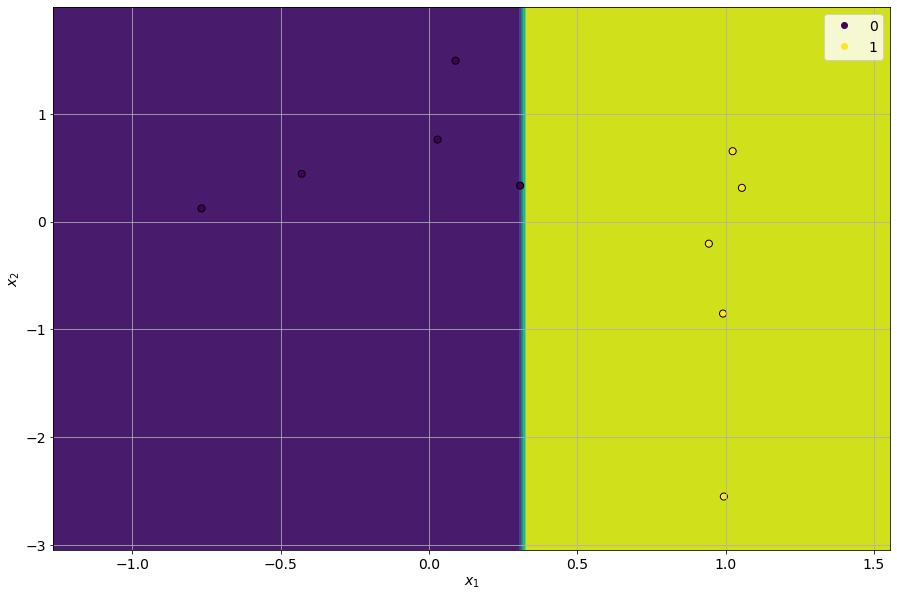

In [16]:
X = X_data
y_true = y_data

x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
xx, yy = np.meshgrid(x1_vals, x2_vals)
space_X = np.c_[xx.ravel(), yy.ravel()]

y_pred = predict_v2(space_X, best_feature_idx, best_threshold)
y_pred = y_pred.reshape(xx.shape)

plt.contourf(xx, yy, y_pred)
pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.show()

Как мы видим, лучшее разделение не произвело деление по 0.5, но тем не менее был найден такой признак и порог для него, который верно разделил все данные в наборе.

Это отличный результат для автоматического построения решающего дерева, состоящего из одного корневого узла. Маленькими шагами мы идем от березки к огромным кедрам!

# Представление структуры дерева

Один из насущных вопросов - как представить дерево в программе? Линейная и логистическая регрессия были формулами, по которым производился расчет, а здесь набор блоков "если" (узлов), причем у каждого должен быть задан индекс признака для разделения и порог.

Но перво-наперво нам нужно взять задачку посложнее, так как эту мы уже решили!

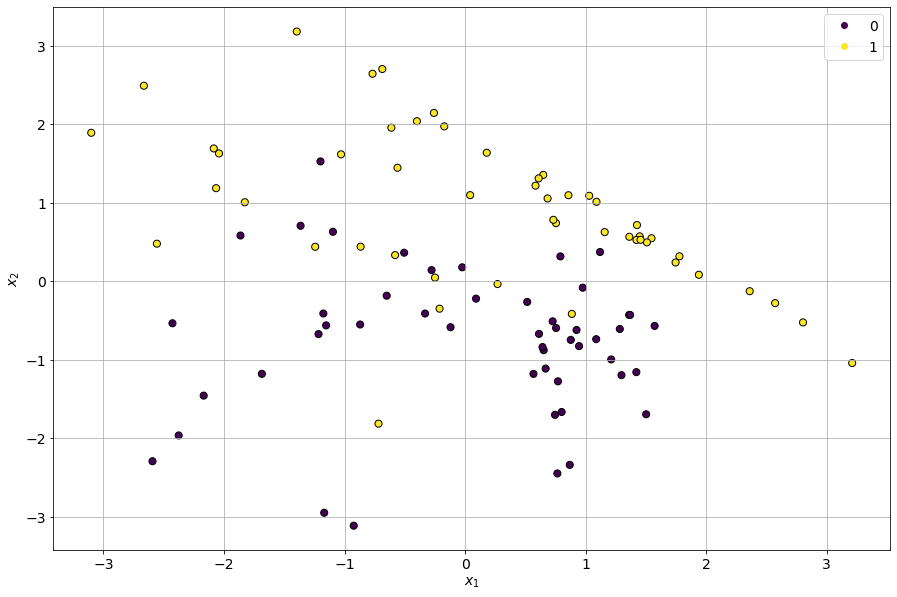

In [17]:
X_data, y_data = make_classification(
    n_samples=100,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=2,
    random_state=3
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

Отлично, непростая задачка, но посмотрим, как справится полноценное решающее дерево!

Давайте немного разберемся, как мы будем строить дерево. Здесь мы воспользуемся инструментом, которым можно как совершать великие дела, так и запросто выстрелись себе в ногу - **рекурсия**.

> Если вы не помните, что такое рекурсия - обязательно обсудите с преподавателем! А ещё можете посмотреть [сюда](https://medium.com/nuances-of-programming/%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%81%D0%B8%D1%8F-%D0%B8-%D1%86%D0%B8%D0%BA%D0%BB-%D0%B2-%D1%87%D0%B5%D0%BC-%D1%80%D0%B0%D0%B7%D0%BD%D0%B8%D1%86%D0%B0-%D0%BD%D0%B0-%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%B5-python-5f0064cc035f) 

![Решающее дерево](https://docs.google.com/uc?export=download&id=11RQsovSMaIgXnNDZrbytHC4xsoQi9Gxb)

Смотрите, что мы будем делать. Мы имеем данные и нужно как-то построить дерево. Мы уже умеем выбирать разделение данных так, чтобы получить наибольший прирост Джини. Теперь нам нужно применить это знание, чтобы построить целое дерево!

Начинаем мы с того, что создаем узел и передаем ему на обучение данные. Что может узел сделать с этими данными? Правильно, найти лучшее разделение! Полученный индекс признака и порог значения признака для разделения узел должен как-то запомнить, так как эти значения больше никак не изменятся. После этого те данные, которые были переданы для обучения мы делим с помощью найденных параметров (индекс признака и порог) на две "кучки" - та, что больше порога по этому признаку (правая), и та, что меньше (левая).

Итого, узлу дали данные, а он нашел параметры разделения и поделил данные. Что делаем дальше? Создать два узла и в левый узел передать левую кучку данных для обучения а в правый - правую кучку.

Если вы еще не заметили, где тут рекурсия, то вот она: самый первый узел в процессе обучения вызывает обучение дочерних (своих) узлов, а те вызывают обучение своих и так далее. То есть по сути, первый узел не закончит обучение, пока не закончат остальные...

Но вот вопрос, а когда узлы закончат множиться? У дерева ведь должны быть листья, но мы их даже не обсуждали! Все верно, нам нужно определить условия, при которых нам нужно вместо нового узла создавать лист, который прервет рекурсию.

Не будем таить и просто обсудим три основных условия, при которых нам нужно создавать узел:
- Самое простое, если дерево слишком глубокое, то пора бы уже останавливаться; то есть зададимся максимальной глубиной и при построении нам нужно следить за тем, на какой глубине учится узел и, если, узел уже на максимальной глубине, то сразу делаем листья без всяких раздумий;
- Еще одна несложная идея - задаемся минимальным количеством данных для обучения узла и, если после разделения внутри узла у нас в ветке (левой или правой) слишком мало данных, то делаем на этой ветке лист.
- Последняя и самая простая - если так случилось, что после разделения в кучке (левой или правой) остались данные одного единственного класса, то смысл еще делить? Сразу делаем лист!

Окей, вот мы создали лист и даже передали ему кучку данных после деления узла, что ему с ними делать? Учится лист очень просто - смотрим на данные и выясняем, записей какого класса в этих данных больше. Выяснили превалирующий класс - все, лист его запоминает и дальше он за этот класс и отвечает! Вот так просто!

Итого:
- Создаем первый узел;
- В узле ищем лучший сплит и запоминаем параметры;
- Делим данные на две кучки;
- Проверяем условия для каждой кучки и решаем, слева и справа создаем новый узел или лист;
- Вне зависимости от того, что создали передаем на обучение кучку (левому узлу/листу - левую кучку, с правой точно также);
- Если узел, то все начинается с начала этого алгоритма;
- Если лист, то выясняем мажорный класс в данных (данных которого больше в разметке), лист его запоминает и мы ничего нового не создаем.

Как только все узлы понасоздают листы, то алгоритм завершится. Вот так несложно работает создание решающего дерева!

Остался последний вопрос, а как предсказывать то? Вот дерево рекурсивно создано, теперь нам надо получить предсказания обученного дерева. Тут тоже несложно, давайте разберемся!


Если нам на предсказание поступает всего одна запись (одномерный вектор), то нет никаких проблем - мы его спускаем по узлам, пока не попадем на конкретный лист. Тот класс, который присвоен листу в результате обучения и будет предсказываемым классом!

> Обратите внимание, во время предсказания ничего не строится!

А что если на вход поступает набор новых данных (2D матрица)? Мы делаем похожим образом, как делали во время построения.

![Решающее дерево](https://docs.google.com/uc?export=download&id=1cH-lEsm9L57sGyrU_3DNyyx4zaOvQIhF)

На самый верхний (корневой) узел поступают данные. Этот узел имеет параметры разделения, поэтому узел делит данные на две группы и передает группы на ветви. Если данные (уже меньше, после разделения) попадают снова на узел, то делается то же самое. Снова рекурсия!

По сути, проход по узлам только и делает, что делит данные и снова вызывает `predict()` левого и правого элемента.

Как только какая-то часть данных попадает на лист, то он всем этим записям присваивает класс листа. Так информация о присвоении возвращается обратно, так как все равно все узлы так или иначе заканчиваются листами!

Вот так несложно работает принцип прохода по решающему дереву для предсказания! Теперь пора написать наш код построения дерева и предсказания деревом!

Смотрите, нам нужно, чтобы узлы и листы хранили информацию внутри себя и удобно создавались, так как делать мы это будем часто! Прекрасно, классы и объекты - то, что нам нужно!

Так как вся структура состоит из листов и узлов, то у нас и будет два класса: `DecisionLeaf` и `DecisionNode`. Между ними будет много общего, чтобы упростить написание кода. Такой подход называется **единообразным интерфейсом**, когда разные классы имеют одинаковые методы с одинаковыми аргументами. Это позволяет передавать данные на обучение или предсказание, не задумываясь о том, кому передаются данные!

Сначала проработаем, какие общие черты будут у обоих классов:
- принимать аргументом конструктора глубину, на которой они располагаются, чтобы затем узнать, какая глубина у всего дерева;
- иметь методы для предсказания и обучения `.predict()` и `.fit()`;
- иметь вспомогательные методы `.get_max_depth()`, который будет давать информацию о глубине, и `.print()`, который будет выводить информацию об элементе;

Для начала выполним реализацию листа дерева. Метод для обучения листа `.fit()` будет заключаться в том, чтобы взять данные, которые приходят на этот лист для обучения и выбрать наиболее часто встречающийся класс, чтобы присвоить его листу. Так мы запомним, за какой класс отвечает этот лист!

Суть метода предсказания `.predict()` проста - выдать класс листа, но только не просто число, а вектор с таким же размером (1D), сколько записей пришли на `predict()` листу. Мы ведь всем этим данным присваиваем класс листа! 

Метод получения информации о глубине `.get_max_depth()` просто вернет глубину листа, на котором он находится.

In [18]:
class DecisionLeaf:
    def __init__(self, depth):
        ''' Конструктор класса
        Аргументы
        ---------
            depth: int
                глубина листа, на котором он располагается
        '''
        self.predict_class = None
        self.depth = depth

    def predict(self, X):
        ''' Функция предсказания листа

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний, заполненный значениями
                класса листа
        '''
        # вектор предсказанных классов
        y_pred=np.full(X.shape[0],self.predict_class)
        return y_pred

    def fit(self, X, y):
        ''' Метод находит в данных класс с наибольшим количеством записей
            и присваивает его листу как наиболее вероятно 
            предсказываемый класс
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''
        # TODO - напишите функцию обучения
        # Выбираем из y наиболее часто встречающееся значение 
        #   и присваиваем self.predict_class
        #   это и будет предсказываемый класс листа
        most_freq=[] # тут хранится число элементов каждого класса
        num_classes = np.max(y)+1 # число классов
        for i in range(num_classes): # делаем число_классов-сравнений
          most_freq.append(np.sum(y==i))
        
        self.predict_class = most_freq.index(np.max(most_freq)) # предсказываем класс

    def get_max_depth(self):
        ''' Получение информации о максимальной глубине
        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        return self.depth

    def print(self):
        ''' Вывод информации о листе '''
        print(f'{self.depth*" "}> Class {self.predict_class}')

In [19]:
# TEST
leaf = DecisionLeaf(1)

assert leaf.get_max_depth() == 1

X = np.array([1, 1, 1, 3]).reshape(-1, 1)
y = np.array([0, 1, 1, 2])
leaf.fit(X, y)

y_pred = leaf.predict(X)
y_true = np.array([1, 1, 1, 1])

assert np.all(y_pred == y_true)
assert np.all(y_pred.shape == y_true.shape)

Отлично, с листом разобрались, теперь реализация узла. 

Обучение узла `.fit()` будет делаться следующим образом:
- получаем лучшее разделение данных, которые поступили на вход;
- сохраняем в аттрибуты узла;
- делаем сплит данных, которые были переданы для обучения;
- проверяем условия создания листа;
    - если надо создать лист - в `self.true_elem` создаем лист;
    - иначе создаем в `self.true_elem` узел;
- передаем в правый элемент левую часть данных (после сплита) в метод `.fit()`;
- то же самое с левой частью данных (`self.false_elem`);

После построения надо сделать реализацию метода предсказания. Метод предсказания `.predict()` будет заключаться в том, чтобы разделить поступившие для предсказания данные и передать части в соответсвующие ветки дальше для `.predict()`.


In [20]:
#Текст заголовка по умолчанию
class DecisionNode:
    def __init__(self, depth, depth_limit, min_samples_split):
        ''' Конструктор класса
        Аргументы
        ---------
            depth: int
                глубина узла, на которой он располагается

            depth_limit: int
                максимальная глубина дерева
            
            min_samples_split: int
                минимальное количество записей для создания узла
        '''
        # Глубина, на которой узел находится
        self.depth = depth
        # Максимальная глубина
        self.depth_limit = depth_limit
        # Минимальное количество записей после сплита, чтобы создать узел
        self.min_samples_split = min_samples_split
        # Индекс признака, по которому узел делает разделение
        self.feature_index = None
        # Порог для разделения
        self.threshold = None

        # Аттрибуты для веток (правая ~ true, левая ~ false)
        self.true_elem = None
        self.false_elem = None
    
    def _create_new_element(self, X, y):
        ''' Метод создания нового элемента
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''
        # Если в разметке остались уникальные классы - создаем лист
        if len(set(y)) == 1:
            return DecisionLeaf(self.depth+1)
        # TODO - допишите ограничения 
        #   на минимальное количество записей в данных
        #   и ограничение глубины
        if (len(y) <= self.min_samples_split): # если данных меньше, чем минимум
          return DecisionLeaf(self.depth+1) # создаем лист (иначе создаем узел)  
        if (self.depth>=self.depth_limit-1): # если глубина еще позволяет
        # , сощдаем лист
            return DecisionLeaf(self.depth+1) 
          
        # Если так и не вернули лист - то возвращаем узел
        # У него увеличиваем глубину на 1 и пробрасываем инфу об ограничениях
        return DecisionNode(
            self.depth+1, 
            self.depth_limit,
            self.min_samples_split
        )



    def predict(self, X):
        ''' Функция предсказания узла

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        # TODO - напишите реализацию метода предсказания

        # Получите маску разделения
        mask = X[:,self.feature_index]>self.threshold
        right_X = X[mask]
        left_X=X[~mask]
        # Вот формируем вектор предсказания
        prediction = np.ndarray(X.shape[0], dtype=int)

        # Вот заполняем предсказания одной ветви
        prediction[~mask] = self.false_elem.predict(left_X)
        
        # Сделайте заполнения для второй ветви
        prediction[mask] = self.true_elem.predict(right_X)

        return prediction

 
    def gini_impurity(self,y):
        if (y.shape[0] == 0):
          return 0
        gini0 = (np.sum(y==0)/y.shape[0])*(1-np.sum(y==0)/y.shape[0])
        gini1 = (np.sum(y==1)/y.shape[0])*(1-np.sum(y==1)/y.shape[0])
        gini = gini0 + gini1
        return gini      

    def get_best_split(self,X, y_true):
        best_gini_gain = 0
        best_gini_impurity = 0
        best_feature_idx = 0
        best_threshold = 0
    
        gini_full = self.gini_impurity(y_true)

        # TODO - дополните реализацию функции получения наилучшего разделения

        for i in range(X.shape[1]):# признаки
          for j in range(X.shape[0]): # записи
            split_mask = (X[:, i] >  X[j,i]) # сранививаем все записи с 
          # признаком - порогом
            y_true_left = y_true[split_mask]
            y_true_right = y_true[~split_mask]  

         # вычисляем примеси джини
            gini_left = gini_impurity(y_true_left)
            gini_right = gini_impurity(y_true_right)

        # взвешиваем
            weight_left = len(y_true_left)/len(y_true)
            weight_right = len(y_true_right)/len(y_true)
        
        # взвешенная джини
            weighted_gini = weight_left * gini_left + weight_right * gini_right
        
        # проверяем разницу в приросте Джини
            prirost = gini_full-weighted_gini

            if (prirost > best_gini_gain):
              best_feature_idx = i
              best_threshold =  X[j,i]
              best_gini_impurity = weighted_gini
              best_gini_gain = prirost
        
        return  best_feature_idx, best_threshold

    def fit(self, X, y):
        ''' Метод обучения узла
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''

        self.feature_index, self.threshold = self.get_best_split(X, y)
        # Вот здесь мы создаем маску для деления
        mask = X[:, self.feature_index] > self.threshold
        right_X = X[mask]
        right_y = y[mask]

        self.true_elem = self._create_new_element(right_X, right_y)
        self.true_elem.fit(right_X, right_y)
        
        # Вам нужно сделать аналогичные действия для другой ветки

        left_X = X[~mask]
        left_y = y[~mask]

        self.false_elem = self._create_new_element(left_X, left_y)
        self.false_elem.fit(left_X, left_y)

    def get_max_depth(self):
        ''' Получение информации о максимальной глубине
        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        # Берем максимум от максимальной глубины по веткам
        return max([
            self.true_elem.get_max_depth(), 
            self.false_elem.get_max_depth()
        ])
    
    def print(self):
        ''' Вывод информации об узле '''
        print(f'{self.depth*" "}| {self.feature_index} > {self.threshold}')
        self.true_elem.print()
        self.false_elem.print()

In [21]:
# TEST
# Допустим, что узел на уровне 1 и максимальная глубина = 2
# Ограничение на минимальное количество уберем
node = DecisionNode(1, 2, 0)

X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 0])
node.fit(X, y)

y_pred = node.predict(X)
y_true = np.array([0, 0, 1, 1, 1])

assert node.get_max_depth() == 2
assert np.all(y_pred == y_true)
assert np.all(y_pred.shape == y_true.shape)

Уф, немаленький класс получился! Осталось написать класс, который будет зваться `DecisionTree` и являться по сути нашей моделью!

> На самом деле могли бы прямо так использовать класс `DecisionNode`, но мы создаем класс-обертку, как для того, чтобы было понятно по названию, так и для того, чтобы можно было в будущем какие-то отдельные вещи в нем реализовывать.

In [22]:
class DecisionTree:
    def __init__(self, depth_limit, min_samples_split):
        ''' Конструктор класса
        
        Аргументы
        ---------
            depth_limit: int
                максимальная глубина дерева
            
            min_samples_split: int
                минимальное количество записей для создания узла
        '''
        self.root = DecisionNode(0, depth_limit, min_samples_split)

    def predict(self, X):
        ''' Функция предсказания узла

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        return self.root.predict(X)

    def fit(self, X, y):
        ''' Функция обучения

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных
        '''
        self.root.fit(X, y)

    def get_depth(self):
        ''' Получение информации о глубине дерева

        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        return self.root.get_max_depth()
    
    def print(self):
        ''' Вывод информации о дереве '''
        self.root.print()

In [23]:
# TEST
X = X_data
y_true = y_data

# Снимем ограничения дерева
# Не ограничиваем глубину и минимальное кол-во записей для узла
tree = DecisionTree(100, 0)
tree.fit(X,y_true)

assert tree.get_depth() == 6

In [24]:
tree.print()

| 1 > -0.18139161596997877
 | 1 > 0.3745125530056157
  | 0 > -1.096615964304849
   > Class 1
   | 0 > -1.2439900718574142
    > Class 0
    | 1 > 0.7091967442272131
     > Class 1
     | 1 > 0.48095734722628103
      > Class 0
      > Class 1
  | 0 > 1.1187257041052354
   > Class 1
   | 0 > -0.5810000805093616
    | 1 > 0.04912870149405335
     > Class 0
     | 0 > 0.2684264804344745
      > Class 0
      > Class 1
    > Class 1
 | 0 > 1.5712194041070418
  > Class 1
  | 1 > -0.42680267791699533
   | 0 > 0.5144652486005934
    > Class 1
    | 0 > -0.3325225345080114
     | 0 > -0.21235292176894527
      > Class 0
      > Class 1
     > Class 0
   | 1 > -1.8111327315138177
    > Class 0
    | 1 > -1.9609526821607552
     > Class 1
     > Class 0


Если дерево обучилось, тест на соответствующую глубину пройден - можно взглянуть на пространство принятия решений:

In [25]:
def plot_tree_decision_space(X, y_true, tree):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
    xx, yy = np.meshgrid(x1_vals, x2_vals)
    space_X = np.c_[xx.ravel(), yy.ravel()]

    y_pred = tree.predict(space_X)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])
    plt.show()

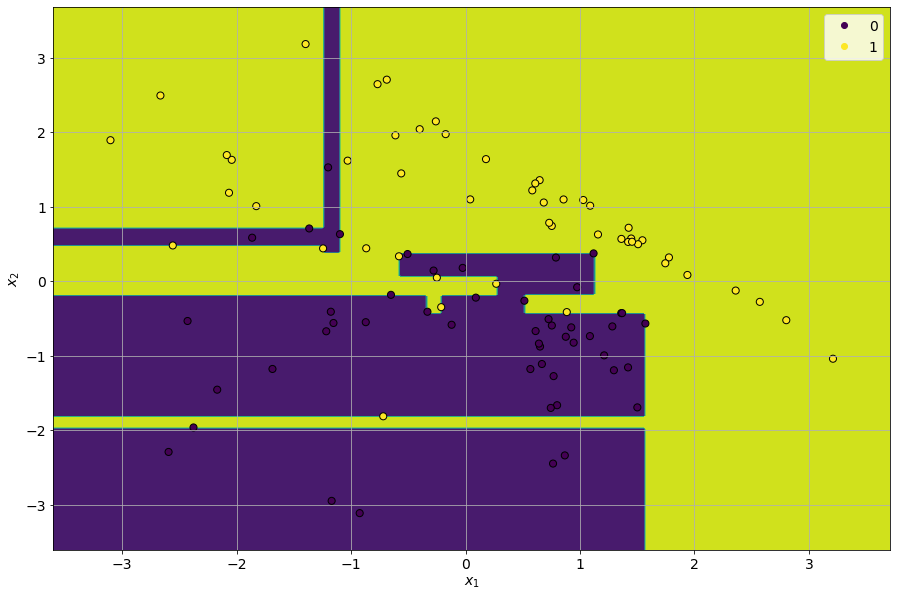

In [26]:
plot_tree_decision_space(X, y_true, tree)

Обратите внимание, как нелинейно произошло разделение пространства! Давайте для простой проверки посмотрим, сколько элементов не соответсвует вектору истинных значений:

In [27]:
y_pred = tree.predict(X)
print((y_pred != y_true).sum())


0


Ради интереса добавим матрицу ошибок.

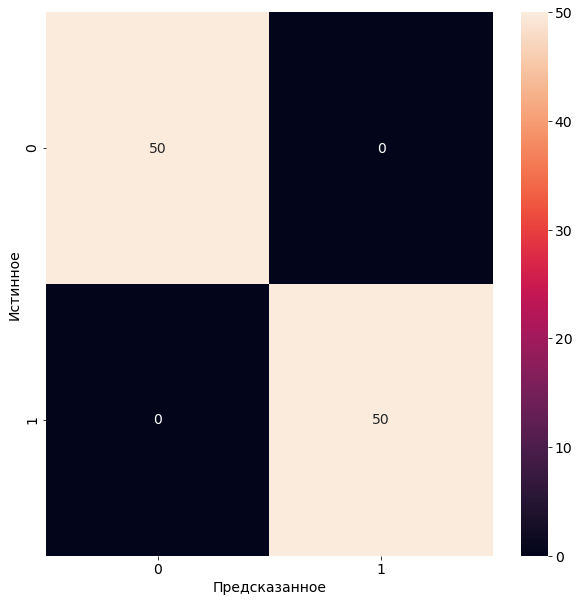

In [28]:
def get_confusion_matrix(y_true, y_pred):
    # TODO - функция генерации матрицы ошибок по векторам предсказания/разметки
    num= np.max(y_true) + 1; # число классов
    conf_mtrx = np.ndarray((num, num))# массив для матрицы ошибок
    for i in range(num):
      for j in range(num):
        conf_mtrx[i,j] = np.sum((y_true == i)*(y_pred == j))
    return conf_mtrx

def draw_confusion_matrix(conf_mtrx):
    # TODO - функция отображения матрицы ошибок
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(conf_mtrx, annot=True)
    plt.xlabel('Предсказанное')
    plt.ylabel('Истинное')
    plt.show()

conf_mtrx = get_confusion_matrix(y_true, y_pred)
draw_confusion_matrix(conf_mtrx)

Вот это да! Вектор предсказаний полностью соответствует вектору
истинных значений! В таких ситуациях важно не поддаться избыточной радости - важно всячески проверить, насколько хорошо работает модель.

## Задание

Произведите разделение на обучение/тест выборки, обучите дерево и отобразите матрицу ошибок.

In [29]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.7
X = X_data
y = y_data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(70, 2) (70,)
(30, 2) (30,)


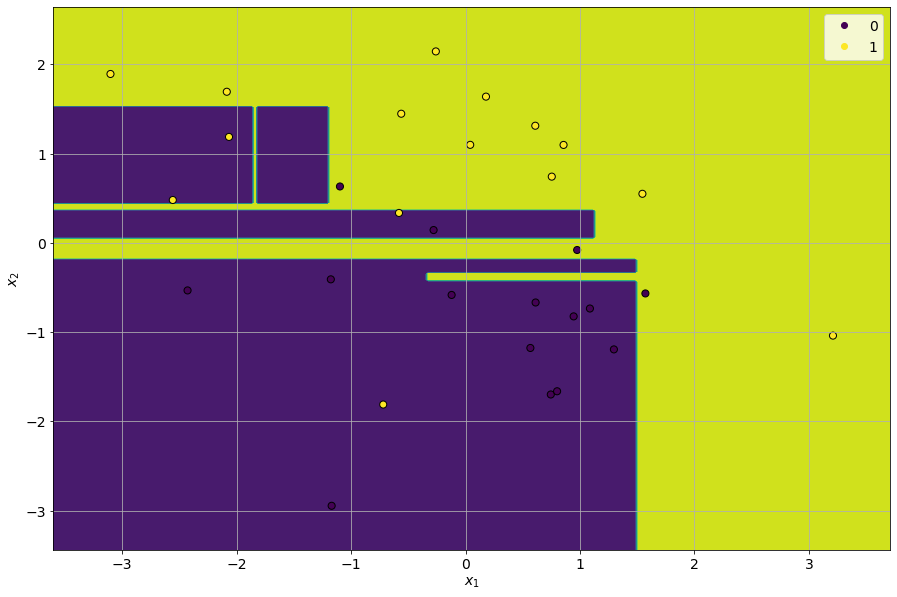

In [30]:
# Не ограничиваем глубину и минимальное кол-во записей для узла
tree = DecisionTree(100, 0)
# обучаем
tree.fit(X_train,y_train)
# классифицируем
y_pred = tree.predict(X_test)

plot_tree_decision_space(X_test, y_test, tree)

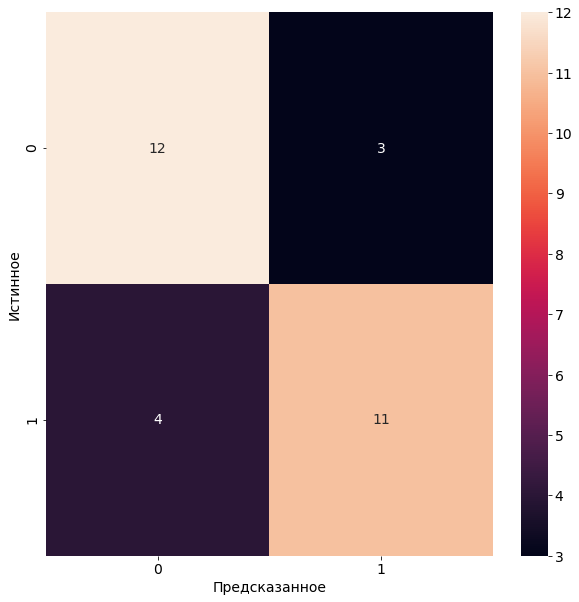

In [31]:
conf_mtrx = get_confusion_matrix(y_test, y_pred)
draw_confusion_matrix(conf_mtrx)

In [32]:
print((y_pred != y_test).sum())

7


По результатам проверки мы увидели, что наше дерево переобучилось. Почему так случилось? Потому что это одна из основных особенностей решающих деревьев - **без каких-либо ограничений дерево точно переобучится**. Ведь дерево может бесконечно долго учиться, пока не разделит данные идеально.

## Задание

Определите наилучшие показатели для дерева с ограничением по показателю f1 кроссвалидацией путем перебора двух параметров. Постройте таблицу и отобразите ее с помощью `seaborn.heatmap()`.

> Для вычисления показателя воспользуйтесь функцией из модуля `sklearn.metrics.f1_score` https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

> Для получения К-фолд со стратификацией воспользуйтесь функцией из модуля `sklearn.model_selection.StratifiedKFold` https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [33]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold 

def cross_val_score_f1(model, k_folds, X, y):
    f1_values = []
    # TODO - напишите функцию получения оценки кросс-валидацией
    skf = StratifiedKFold(n_splits=k_folds,
                          random_state=RANDOM_STATE,
                          shuffle=True)
    for train_indexes, test_indexes in skf.split(X, y):
      X_train,X_test = X[train_indexes],X[test_indexes]
      y_train,y_test =  y[train_indexes],y[test_indexes]
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      f1 = f1_score(y_test, y_pred)
      f1_values.append(f1)

    return np.mean(f1_values)

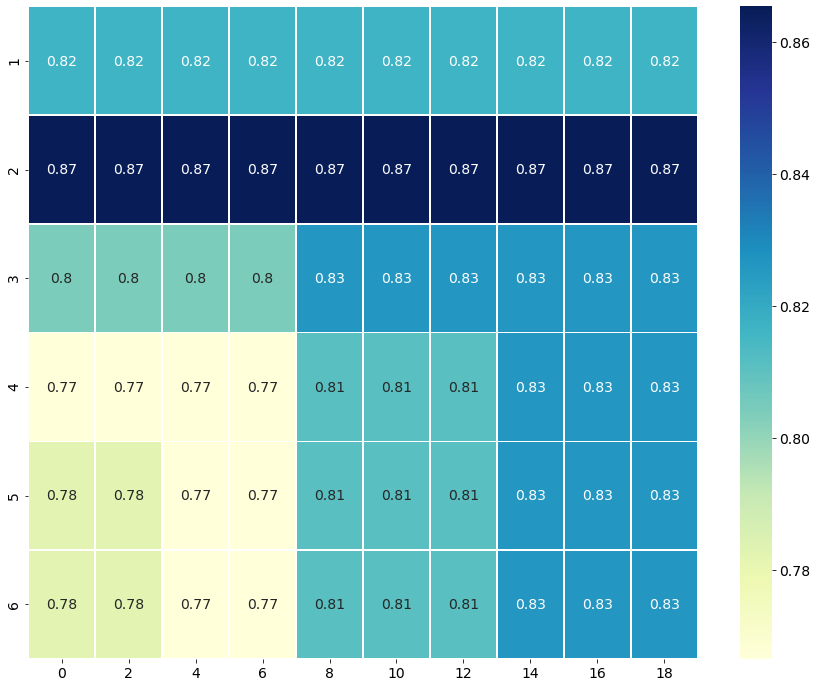

In [34]:
X = X_data
y_true = y_data
f1 = []
for depth_limit in range(1, 7):
    for min_samples in range(0, 20, 2):
        tree = DecisionTree(depth_limit,min_samples)
        f1_value = cross_val_score_f1(tree, 5, X, y_true)
        f1.append(f1_value)
# меняем размерность со строки 
f1_scores = np.reshape(f1,(np.shape(range(1, 7))[0],np.shape(range(0, 20, 2))[0]))
# создаем датафрейм
panda_f1_scores=pd.DataFrame(data = f1_scores, index=range(1, 7),columns=range(0, 20, 2))
plt.figure(figsize=(15,12))
sns.heatmap(panda_f1_scores, annot=True,cmap="YlGnBu",linewidths=.5)
plt.show()


После того, как мы успешно вырастили дерево самое время вырастить лес из таких деревьев! Но перед этим нам надо познакомиться с такими понятиями как **ансамблирование** и **бэггинг**.

# Ансамблирование (Ensemble)

Всем известно определение слова ансамбль (из большой советской энциклопедии):
> Ансамбль I Анса́мбль (франц. ensemble, буквально — вместе, сразу)
совокупность, стройное целое.

Идея ансамблирования в машинном обучении заключается в том, что какой бы супер-классификатор мы не сделали, много маленьких слабых классификаторов, работающих вместе, будут выполнять задачу лучше.

Как мы ранее видели, такой классификатор, как решающее дерево, при сильном ограничении не позволяет достаточно разделить пространство, чтобы отразить зависимость в данных, а при слабом ограничении растет и запоминает данные, что приводит к переобучению. Группа таких классификаторов же может дать хороший результат, даже если каждый из них будет совершать ошибки, то усреднение результатов может дать более точный ответ.

Для организации обучения используется второй термин, который мы рассмотрим.

> Еще, можете почитать про историю с быком и что такое "Мудрость толпы": https://econs.online/articles/ekonomika/sila-i-slabost-kollektivnogo-razuma/

# Бэггинг (bagging)

Термин является сокращением от **b**ootstrap **agg**regat**ing**. Методика бутстрэпинга (bootstraping) известна в статистике и заключается в том, что для усредненной оценки показателей все данные делятся на группы. Эти группы могут пересекаться, то есть, например, у нас есть массив чисел:
$$
\begin{bmatrix}
0 & 1 & 2 & 3 & 4
\end{bmatrix}
$$

Мы создаем две выборки по четыре элемента в каждой, тогда метод бутстрэпинга может дать результат
$$
\begin{bmatrix}
0 & 3 & 3 & 1
\end{bmatrix}
и
\begin{bmatrix}
1 & 4 & 2 & 4
\end{bmatrix}
$$

> Сам по себе метод бутстрэпинга - это метод выборки, при котором мы берем случайную (по равномерному распределению) запись из данных, заносим ее в новую выборку, но не исключаем из исходных данных. Тогда эта же запись может попасть в ту же выборку еще раз.

> Можно проверить, если взять исходные данные вычислить среднее, а затем создать несколько бутстреп выборок и получить усредненное из средних значений каждой выборки. Исходное среднее и усредненное значение средних должны быть приблизительно равны.

Так при чем тут бэггинг?

Бэггинг, являясь одним из простых методов ансамблирования, берет идею таких выборок: положим, что имеются данные с $N$ записями, тогда создадим $D$ бутстрэп выборок (каждая размером $N$) и обучим $D$ моделей, каждая на своем кусочке. В чем преимущество такого подхода?

> Модели не видят всех записей данных, так что переобучение каждой модели на своем кусочке данных не так страшно - так как результаты модели усредняются, то переобученность каждой из моделей на части данных не сказывается на конечном предсказании.

Для практики реализуем метод генерации бутстрэп выборок из исходных данных: 

In [35]:
def generate_bootstrap_sets(X, D):
    ''' Генерация D выборок из исходных данных

    Параметры
    ---------
    X: [n_samples, n_features]
        Исходные данные
    
    D: int
        Количество выборок для генерации

    Возвращает
    ----------
    boostrapped_sets: list
        Список, состоящий из бутстрэп-выборок данных размером [n_samples, n_features]
    ''' 

    bootstrapped_sets = []
    # TODO - напишите реализацию генератора выборок
    for i in range(D):
      # выбираем рандомные элементы массива размером (n_samples, n_features)
      rand_mass = np.random.choice(X.flatten(), (X.shape[0]*X.shape[1]))
      # правильная размерность
      rand_mass = np.reshape(rand_mass,(X.shape[0],X.shape[1]))
      # добавляем 
      bootstrapped_sets.append(rand_mass)
    return bootstrapped_sets

In [36]:
X = np.array([
    [1, 2, 3],
    [5, 7, 9],
    [-2, 0, 3],
    [-1, 9, 2],
])

boostrapped_Xs = generate_bootstrap_sets(X, 3)

assert len(boostrapped_Xs) == 3
assert boostrapped_Xs[0].shape == X.shape
assert boostrapped_Xs[1].shape == X.shape
assert boostrapped_Xs[2].shape == X.shape

# **ДОШЕЛ ДО СЮДА!**

# Бэггинг над решающими деревьями

После реализации функции генерации бутстрэп выборок мы можем проверить работоспособность подхода ансемблирования, действительно ли он работает лучше, чем одно решающее дерево.

Реализацию построим по тому же принципу на основе классов. Создадим класс `BaggingDecisionTrees`, который будет также иметь методы `.predict()` и `.fit()`. В качестве аргументов конструктора будем задавать количество деревьев для генерации и максимальную глубину деревьев.

In [52]:
class BaggingDecisionTrees:
    def __init__(self, ensemble_size, depth_limit, min_samples_split):
        self.ensemble_size = ensemble_size
        self.depth_limit = depth_limit
        self.min_samples_split = min_samples_split
    
        # TODO - Напишите код создания необходимого количества решающих деревьев
        self.trees = []
        for i in range(ensemble_size):
            tree = DecisionTree(depth_limit=self.depth_limit, min_samples_split=self.min_samples_split)
            self.trees.append(tree)

    def predict(self, X):
        predicts = []
        result_predictions = np.ndarray(X.shape[0], dtype=int)
        # TODO - Получите предсказания каждого дерева в массив predicts
        for tree in self.trees:
            predict=tree.predict(X)
            predicts.append(predict)
        # А вот так мы получим голосование по каждой записи
        # Так как у нас predict - это массив (n_samples, ensemble_size),
        #   то по каждой записи проводим голосование 
        #   и выбираем наиболее частый класс среди предсказаний моделей
        predicts = np.array(predicts).T
        for i_s in range(predicts.shape[0]):
            (uniques, counts) = np.unique(predicts[i_s], return_counts=True)
            most_frequent = uniques[np.argmax(counts)]
            # TODO - осталось заполнить правильное значение 
            #   в векторе предсказаний
            result_predictions[i_s]=most_frequent 
        return result_predictions

    def generate_bootstrap_sets(self,X, D):
        bootstrapped_sets = []
        for i in range(D):
          # выбираем рандомные элементы массива размером (n_samples, n_features)
          rand_mass = np.random.choice(X.flatten(), (X.shape[0]*X.shape[1]))
          # правильная размерность
          rand_mass = np.reshape(rand_mass,(X.shape[0],X.shape[1]))
          # добавляем 
          bootstrapped_sets.append(rand_mass)
        return bootstrapped_sets

    def fit(self, X, y):
        # Так мы объединили данные для генерации выборок
        Xy = np.c_[X, y]
        # TODO - добавьте здесь генерацию выборов
        boostrapped_Xy = self.generate_bootstrap_sets(Xy, self.ensemble_size)
        for i, Xy in enumerate(boostrapped_Xy):
          X = Xy[:, :-1]
          y = Xy[:, -1]
          # TODO - здесь добавьте обучение i-го дерева
          self.trees[i].gofit(X,y)

In [ ]:
X = X_data
y_true = y_data

bag_tree = BaggingDecisionTrees(
    ensemble_size=10, 
    depth_limit=3, 
    min_samples_split=2
)
bag_tree.fit(X, y_true)
y_pred = bag_tree.predict(X)

assert len(bag_tree.trees) == 10
assert np.all(y_pred.shape == y_true.shape)

In [ ]:
plot_tree_decision_space(X, y_true, bag_tree)

## Задание

Определите наилучшие параметры для бэггинга над решающими деревьями путем перебора трех параметров. Для каждого параметра зафиксируйте список проверяемых значений и в трех циклах перебором подставляйте значения и определите лучшие для данной модели.

In [ ]:
# TODO

# Поиск гиперпараметров методом сетки

> **Гиперпараметры** - параметры, относящиеся к структуре или метаинформации модели. Так называются, потому что термин **параметры** относится к обучаемым сущностям в модели (веса, узлы и т.д.). Гиперпараметры в свою очередь не обучаются, а устанавливают то, насколько модель велика, коэффициенты регуляризации и др.

Методы поиска гиперпараметров различны, но мы рассмотрим один из наиболее распространенных - метод поиска сеткой.

На самом деле, мы уже его рассмотрели и даже практиковались - в прошлом задании! Суть метода заключается в том, что для каждого гиперпараметра фиксируется набор значений и далее перебором всех возможных комбинаций кросс-валидацией производится поиск лучшего набора параметров.

Вот так, вроде умное название, а метод очень простой!

Другой известный метод - метод случайного поиска. В данном методе комбинации создаются не за счет заданных значений гиперпараметров, а заданием диапазона значений и уже далее для каждой комбинации конкретное значений получают за счет случайного выбора из этого диапазона.

В качестве практики попробуйте реализовать метод случайного поиска гиперпараметров:

In [ ]:
# TODO - реализуйте поиск лучшего варианта бэггинга над решающими деревьями методом случаного выбора гиперпараметров

# Случайный лес

Наконец, перейдем к понятию случайного леса, ведь кажется, ансамбль деревьев и есть случайный лес, разве нет? Ответ: не совсем. В ходе развития метод бэггинга стал основополагающим в построении работы случайного леса, но существует очень важное отличие!

Заключается оно в методе разделения узла в дереве. До этого для получения наилучшего сплита мы рассматривали все $N$ записей и все $M$ признаков, чтобы найти наилучшее разделение. Случайный лес вводит маленькое ограничение: для получения сплита рассматриваются не все признаки из данных, а лишь $F (< M)$ случайных признаков.

> Для задач классификации рекомендуется брать $F = \sqrt{M}$ признаков. Мы не рассматриваем деревья для регрессии, но там такие же принципы и там рекомендуется брать $F = M/3$.

Теперь, для реализации модифицируем класс `DecisionNode`, добавив новый гиперпараметр. Это требуется сделать как в конструкторе, так и в логике обучения. Метод обучения будет изменен таким образом, что функции поиска лучшего сплита будут переданы не все колонки из данных, а лишь указанное в гиперпараметре количество. Выбираться колонки будут случайно.

Следующее задание на написание кода будет нестандартным. Обычно так делать не приходится, но из-за системы в Jupyter нам нужно в следующую кодовую ячейку вставить старую реализацию `DecisionNode` и модифицировать ее:
- добавить в конструктор аргумент `max_features` и сохранить его в атрибутах объекта (`self.max_features = max_features`);
- при создании нового узла ему нужно передавать значение `self.max_features`;
- в методе `.fit()` добавьте формирование новой матрицы данных, в которых случано выбраны `max_feature` признаков (колонок) - может помочь `np.random.choice`; не забывайте, что `get_best_split()` выдает индекс признака по той матрице, которая была передана, а мы ее только что покрамсали по колонкам; 

<details>
<summary>Подсказка по последней части</summary>

```Python
        split_feature_indices = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
        _, best_feature_idx, best_threshold = get_best_split(X[:, split_feature_indices], y)

        # Не забудьте, что get_best_split не знает об истинных индексах
        self.feature_index = split_feature_indices[best_feature_idx]
```
</details>

In [ ]:
# TODO - сделайте новую реализацию в этой ячейке

Теперь обновим класс `DecisionTree`, добавив новый аргумент:

In [ ]:
class DecisionTree:
    def __init__(self, depth_limit, min_samples_split, max_features):
        ''' Конструктор класса
        Аргументы
        ---------
            depth_limit: int
                максимальная глубина дерева
            
            min_samples_split: int
                минимальное количество записей для создания узла

            max_features: int
                максимальное количество признаков для деления
        '''
        self.root = DecisionNode(0, depth_limit, min_samples_split, max_features)

    def predict(self, X):
        ''' Функция предсказания узла

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        return self.root.predict(X).astype(int)

    def fit(self, X, y):
        ''' Функция предсказания

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        self.root.fit(X, y)

    def get_depth(self):
        ''' Получение информации о глубине дерева
        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        return self.root.get_max_depth()
    
    def print(self):
        ''' Вывод информации о дереве '''
        self.root.print()

И напишем реализацию случайного леса!

In [ ]:
class RandomForest:
    def __init__(self, ensemble_size, depth_limit, min_samples_split, max_features):
        self.ensemble_size = ensemble_size
        self.trees = []
        # TODO - Напишите код создания необходимого количества решающих деревьев

    def predict(self, X):
        # TODO - напишите метод предсказания

        return result_predictions

    def fit(self, X, y):
        pass
        # TODO - напишите метод предсказания

Самое время проверить разработанный случайный лес обучением:

In [ ]:
X = X_data
y_true = y_data

rf_clfr = RandomForest(
    ensemble_size=10, 
    depth_limit=3, 
    min_samples_split=2,
    max_features=int(np.sqrt(X.shape[1]))
)
rf_clfr.fit(X, y_true)

y_pred = rf_clfr.predict(X)

assert len(rf_clfr.trees) == 10
assert np.all(y_pred.shape == y_true.shape)

In [ ]:
plot_tree_decision_space(X, y_true, rf_clfr)

## Задание

Найдите лучшие параметры для случайного леса и сравните с лучшим вариантом модели бэггинга над решающими деревьями. Параметр `max_features` менять не требуется. Для оценки как всегда используйте кросс-валидацию.

# Лучшая стандартизация! - Задание

Кто-то может сказать, что все рассматриваемые данные до этого были слишком простыми - а как вам такие? Решаем новую задачку!

Попробуйте найти лучшие параметры для моделей решающего дерева и случайного леса для следующих данных:

In [ ]:
from sklearn.datasets import make_moons

X_data, y_data = make_moons(
    n_samples=1000,
    noise=.1,
    random_state=RANDOM_STATE
)
X_data[:,0] *= 1000

plt.figure(figsize=[15, 9])
pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)

Разработайте лучшие модели, после этого проведите стандартизацию данных и оцените, как она влияет на модели, использующие решающие деревья. То есть сравните работу лучших моделей со стандартизацией и без.

> Если помните, для моделей линейной и логистической регрессий стандартизация играла большую роль! 

In [ ]:
# TODO

# Регрессия для вас - Задание

Мы не рассматривали случай, когда лес (а соответственно и деревья) используется для решения задачи регрессии. Вы уже знаете основные принципы построения деревьев для решения задачи классификации - попробуйте решить задачу регрессии с помощью дерева (а дальше несложно применить и лес). 

Вот вам данные:

In [ ]:
X_data = np.linspace(-1, 7, 200)[:, None]
y_data = np.sin(X_data[:,0])*5 + np.random.normal(size=X_data.shape[0])*2 + 5

# Посмотрим на данные
plt.scatter(X_data[:,0], y_data)
plt.grid(True)
plt.xlabel('Значение признака ($x$)')
plt.ylabel('Истинное значение ($y$)')
plt.show()

Суть задания в том, чтобы самостоятельно написать реализацию класса дерева `DecisionTreeReg` (узла `DecisionLeafReg` и листа `DecisionNodeReg`, соответственно) для задачи регрессии. Отличий очень мало, давайте их рассмотрим:
- Вместо примесей Джини используется уже знакомый MSE;
- В ходе обучения условия создания листа - "максимальная глубина", "минимальное количество данных для нового узла" остаются, проверку на уникальность оставшейся разметки можно убрать;
- Поиск наилучшего сплита раньше делался так:
    - Вычисляем примеси Джини на наборе данных;
    - Берем запись в данных (точку), берем ее первый признак, берем значение этого признака в качестве порога;
    - Делаем сплит по этим параметрам (индекс признака, значение порога)
    - Вычисляем примеси на левой и правой кучках;
    - Берем взвешенную сумму (веса = количество в кучке после сплита / все данные) левой и правой кучек показателей примесей;
    - Проверяем, насколько снизился показатель примесей;
    - Лучший сплит тот, который уменьшил сильнее всего примеси!  
- Теперь мы делаем чуть-чуть по-другому:
    - Вычисляем MSE на наборе данных (предсказание - это среднее значение всего `y`, так что каждую точку отнимаем от среднего по `y`);
    > Ну почти MSE, можно назвать СКО (STD) - средне квадратичное отклонение =)
    - Берем запись в данных (точку), берем ее первый признак, берем значение этого признака в качестве порога;
    - Делаем сплит по этим параметрам (индекс признака, значение порога)
    - Вычисляем MSE (или STD, кто как назовет) на левой и правой кучках; то есть в левой берем среднее и от него отнимаем каждую точку левой кучки, аналогично справа;
    - Берем взвешенную сумму (веса = количество в кучке после сплита / все данные) левой и правой MSE;
    - Проверяем, насколько снизился показатель MSE;
    - Лучший сплит тот, который уменьшил сильнее всего показатель!
- Обучение листа - теперь не большинство в разметке в `y`, а среднее значение `y`;
- Предсказания, у узла то же самое, просто делим данные и доносим до листьев, а вот лист просто предсказывает то среднее, что он запомнил во время обучения;
- `max_features` для задачи регрессии лучше брать не $\sqrt{M}$, а $M/3$;

По сути, самое большое - поменять алгоритм сплита, в остальном почти также)
А что поменяется в лесу? Теперь предсказания 10 деревьев не голосованием выбираются, а просто среднее по всем.

Все достаточно просто, так что верим в себя и дерзайте!


In [ ]:
# TODO - дерево для регрессии

# Выводы - Задание

Напишите выводы по итогам изучения материала. Ниже найдёте вспомогательные вопросы, которые не должны сковывать ваше мышление. Собственное мнение и умозаключения - приветствуются!

1. Что делает дерево, может ли оно заменить задачу регресии? 
2. Зачем нужно понимать глубину дерева? 
3. Как производится оценка разделения дерева? 
4. Зачем нужно останавливать рекурсию? 
5. Почему переобученное дерево - это плохо? 
6. Чем случайный лес отличается от ансамбля деревьев? И отличается ли? Почему важно это знать? 
7. Что делает бэггинг с решающими деревьями? 
8. Нужна ли стандартизация/нормализация признаков для деревьев? Почему?

# Вопросики!

1. Чем отличаются корень, узлы и листья у дерева? Почему внезапно такая ассоциация с деревьями?
2. Зачем нужен порог дереву? 
3. Когда в дереве много примесей - это хорошо, плохо или ещё как-то? 
4. Чем опасна рекурсия и как держать её в узде? 
5. Когда дерево может точно переобучиться? 
6. Что лучше одно супер-дерево или много нормальных таких деревьев? 
7. Как связан бэггинг и ансамблирование? 
8. Что такое бутстрэпинг? 
9. (Вопрос на расширение сознания - гляньте в инет) Что такое показатель энтропии и как его можно использовать при построении деревьев?
10. Почему такое название "обучение с учителем"? Где этот учитель прячется?
11. Можно ли переобучить модель линейной регрессии? 